# Narrative Lens Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

/Users/camilojaureguiberry/Documents/Projects/Developments/NarrativeLens/NarrativeLens/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

Lets start getting some sense of this data

In [2]:
df = pd.read_csv('../../data/datasets/tiktok_topads_clean.csv')
display(df.head())
display(df.info())
display(df.describe())
#df.isnull().sum()
#df.dropna(inplace=True)
display(df.info())


,ad_title,brand_name,cost,ctr,id,like,video_name,is_ugc,duration,height,...,industry_parent,industry_child,objective_value,creative_theme,creative_concept,format_production_style,talent_type,demographic_representation,audience_focus,campaign_objective
0,Great time killer!,Survival Game Master,2,0.01,7132878852058906625,38213,ad_23000000000_2_0_1,True,30.974,1280,...,News & Entertainment,Games & Utility Software,App Installs,Promotional & Offer-Based,Product demo,Native Video,Influencers,Primarily Male,Unaware Audience,App Promotion
1,Oddly satisfying game,Gameworld Master,2,0.01,7109275920046178305,14299,ad_23000000000_2_1_1,False,37.334,1024,...,News & Entertainment,Games & Utility Software,App Installs,Product-Centric,Product demo,Native Video,NaN,No People Featured,Unaware Audience,Awareness
2,My friend recommended me to play this game,Sugarcane Inc. Empire Tycoon,0,0.02,7077499601561305089,2427,ad_23000000000_2_2_1,False,17.323,1024,...,News & Entertainment,Games & Utility Software,App Installs,Educational & Explainer,Product demo,Animation & Motion Graphics,NaN,No People Featured,Unaware Audience,Awareness
3,download now,"Smart VPN - Fast, Stable",2,0.02,7176836203668783106,124771,ad_23000000000_2_3_1,False,53.015,1280,...,News & Entertainment,Games & Utility Software,App Installs,Lifestyle & Aspirational,Before-and-after story,Animation & Motion Graphics,NaN,Primarily Female,Unclear,Engagement
4,Play ten minutes a day to relieve stress!,Sugarcane Factory 3D,0,0.02,7077499507373899777,2739,ad_23000000000_2_4_1,True,14.016,1024,...,News & Entertainment,Games & Utility Software,App Installs,Product-Centric,Product demo,Animation & Motion Graphics,NaN,No People Featured,Unaware Audience,App Promotion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ad_title                    577 non-null    object 
 1   brand_name                  449 non-null    object 
 2   cost                        578 non-null    int64  
 3   ctr                         578 non-null    float64
 4   id                          578 non-null    int64  
 5   like                        578 non-null    int64  
 6   video_name                  578 non-null    object 
 7   is_ugc                      578 non-null    bool   
 8   duration                    578 non-null    float64
 9   height                      578 non-null    int64  
 10  width                       578 non-null    int64  
 11  industry_parent             578 non-null    object 
 12  industry_child              578 non-null    object 
 13  objective_value             578 non

None

,cost,ctr,id,like,duration,height,width
count,578.000000,578.000000,5.780000e+02,5.780000e+02,578.000000,578.000000,578.000000
mean,1.749135,0.034464,7.251701e+18,9.185938e+05,26.691564,1054.934256,602.802768
std,0.453419,0.077994,1.091289e+17,2.127821e+07,30.804232,118.519693,75.781904
min,0.000000,0.010000,6.800257e+18,1.710000e+03,5.388000,572.000000,540.000000
25%,2.000000,0.010000,7.185758e+18,2.821000e+03,12.597500,1024.000000,576.000000
50%,2.000000,0.010000,7.243682e+18,6.011500e+03,19.342500,1024.000000,576.000000
75%,2.000000,0.020000,7.306477e+18,1.654150e+04,30.920750,1024.000000,576.000000
max,2.000000,0.940000,7.486978e+18,5.115653e+08,451.118000,1290.000000,1280.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ad_title                    577 non-null    object 
 1   brand_name                  449 non-null    object 
 2   cost                        578 non-null    int64  
 3   ctr                         578 non-null    float64
 4   id                          578 non-null    int64  
 5   like                        578 non-null    int64  
 6   video_name                  578 non-null    object 
 7   is_ugc                      578 non-null    bool   
 8   duration                    578 non-null    float64
 9   height                      578 non-null    int64  
 10  width                       578 non-null    int64  
 11  industry_parent             578 non-null    object 
 12  industry_child              578 non-null    object 
 13  objective_value             578 non

None

### Brand Name

In [3]:
#What are the brands in this dataset?
print(df['brand_name'].value_counts())

#There are several missing values in the brand_name and then is very sparse
#Lets drop it
df = df.drop(columns=['brand_name'])

brand_name
Celebs News                          12
Bend: Stretching & Flexibility        9
Fabletics Men                         8
FableticsMen                          6
DoorDash                              6
                                     ..
Filter Design Online                  1
Vid-Game                              1
Online & Digital Marketing Degree     1
UX&UI&ME                              1
Survival Game Master                  1
Name: count, Length: 335, dtype: int64


### Cost

In [4]:
#What is the distribution of the cost?
print(df['cost'].value_counts())

cost
2    438
1    135
0      5
Name: count, dtype: int64


### CTR

Axes(0.125,0.11;0.775x0.77)


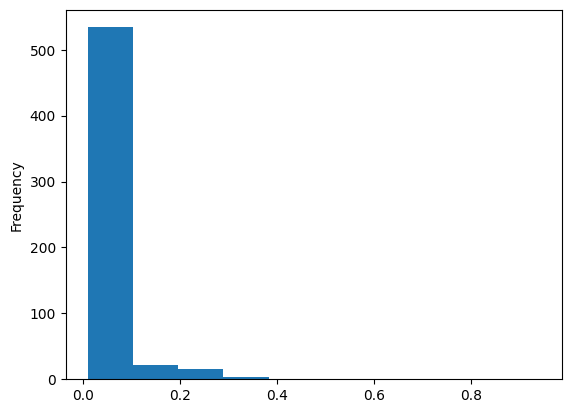

In [5]:
#Whats the distribution of CTR?
print(df['ctr'].plot.hist())
plt.show();

In [6]:
#Strong skew to the right, lets inspect the outliers with IQR method
Q1 = df['ctr'].quantile(0.25)
Q3 = df['ctr'].quantile(0.75)
IQR = Q3 - Q1

df.loc[df['ctr'] > Q3 + 1.5 * IQR]


,ad_title,cost,ctr,id,like,video_name,is_ugc,duration,height,width,industry_parent,industry_child,objective_value,creative_theme,creative_concept,format_production_style,talent_type,demographic_representation,audience_focus,campaign_objective
8,Be My Guest is the new trend,2,0.04,7188113660753313794,2445,ad_23000000000_2_8_1,True,13.014,1024,576,News & Entertainment,Other News & Entertainment,App Installs,Humor & Entertainment,Day-in-the-life story,Animation & Motion Graphics,NaN,No People Featured,Unclear,Unclear
9,Play now or Cry later,2,0.04,7169928916990312449,8503,ad_23000000000_2_9_1,False,30.016,1024,576,News & Entertainment,Other News & Entertainment,App Installs,Humor & Entertainment,Day-in-the-life story,Native Video,NaN,No People Featured,Unclear,App Promotion
10,We are here to support you friends! 🥰💕 #mental...,2,0.05,7183086453202550786,87258,ad_23000000000_2_10_1,True,18.597,1024,576,News & Entertainment,Games & Utility Software,App Installs,Lifestyle & Aspirational,Day-in-the-life story,Native Video,Customers,Primarily Female,Problem Aware,Engagement
11,This is really satisfying!,2,0.06,7176960976629104642,289737,ad_23000000000_2_11_1,False,30.016,1280,720,News & Entertainment,Games & Utility Software,App Installs,Product-Centric,Product demo,Native Video,NaN,No People Featured,Unclear,App Promotion
12,Check it out! We just released our NEW GAME!,1,0.07,7125421394594988034,2610,ad_23000000000_2_12_1,True,30.016,1024,576,News & Entertainment,Games & Utility Software,App Installs,Promotional & Offer-Based,Event-driven,Native Video,NaN,No People Featured,Product Aware,Engagement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,🧟‍♀️🖤💜💚 ZOMBIFIED 💚💜🖤🧟‍♀️ those NEON shades! ...,1,0.38,7157344090140180481,3720,ad_14000000000_14_17_1,True,26.307,1024,576,Beauty & Personal Care,Cosmetics,Product sales,Product-Centric,Product demo,Native Video,Actors,Diverse Gender Representation,Product Aware,Sales
571,Rev up your pet's playtime. The ultimate exerc...,2,0.08,7172740553150382081,3182,ad_19000000000_14_0_1,True,25.334,1024,576,Pets,Pet Toys,Product sales,Product-Centric,Product demo,Native Video,NaN,No People Featured,Problem Aware,Sales
575,You Sold These Out Last Time,2,0.13,7154668616717778946,7150,ad_22000000000_14_3_1,False,9.067,1024,576,Apparel & Accessories,Men's Clothing,Product sales,Product-Centric,Product demo,Native Video,NaN,No People Featured,Unclear,Sales
576,Vintage Inspired Fleeces! Buy yours.,2,0.14,7154671305471754241,4427,ad_22000000000_14_4_1,True,9.126,1024,576,Apparel & Accessories,Men's Clothing,Product sales,Product-Centric,Product demo,Native Video,NaN,No People Featured,Unclear,Awareness


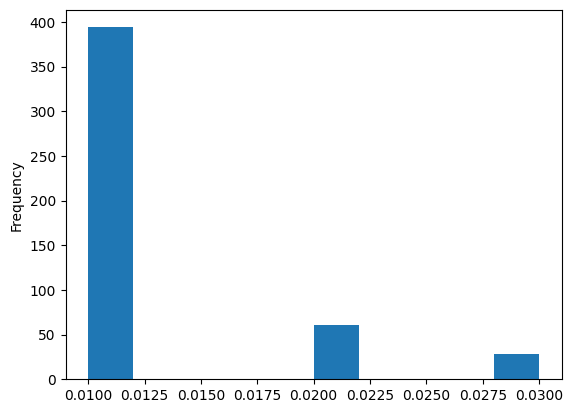

In [7]:
#now lets get rid of them
df = df[df['ctr'] < Q3 + 1.5 * IQR]

df['ctr'].plot.hist()
plt.show();

### Likes

Axes(0.125,0.11;0.775x0.77)


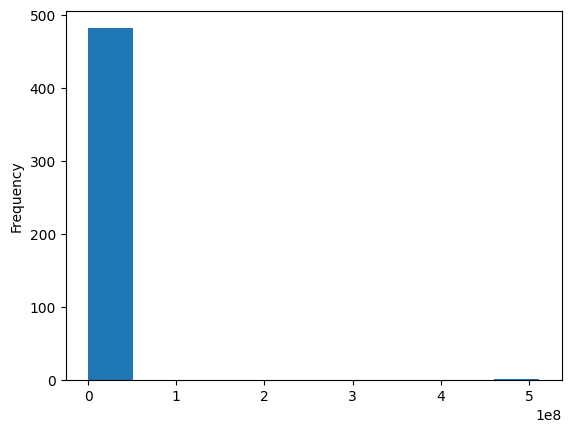

In [8]:
#What is the distribution of the likes?
print(df['like'].plot.hist())
plt.show();

In [9]:
#Looks there's a big outlier in the likes, lets inspect it using the IQR method
Q1 = df['like'].quantile(0.25)
Q3 = df['like'].quantile(0.75)
IQR = Q3 - Q1

df.loc[df['like'] > Q3 + 1.5 * IQR]

,ad_title,cost,ctr,id,like,video_name,is_ugc,duration,height,width,industry_parent,industry_child,objective_value,creative_theme,creative_concept,format_production_style,talent_type,demographic_representation,audience_focus,campaign_objective
0,Great time killer!,2,0.01,7132878852058906625,38213,ad_23000000000_2_0_1,True,30.974,1280,720,News & Entertainment,Games & Utility Software,App Installs,Promotional & Offer-Based,Product demo,Native Video,Influencers,Primarily Male,Unaware Audience,App Promotion
3,download now,2,0.02,7176836203668783106,124771,ad_23000000000_2_3_1,False,53.015,1280,720,News & Entertainment,Games & Utility Software,App Installs,Lifestyle & Aspirational,Before-and-after story,Animation & Motion Graphics,NaN,Primarily Female,Unclear,Engagement
36,Will they get 20 bucks?,2,0.03,7223381121831895041,359895,ad_28000000000_2_5_1,True,31.044,1024,576,Sports & Outdoor,Sports & Equipment,App Installs,Promotional & Offer-Based,Product demo,Native Video,Actors,Primarily Young Adults,Problem Aware,App Promotion
54,Expect anything to happen,1,0.01,7117952658766659586,93864,ad_25000000000_2_7_1,False,30.080,1024,576,Games,Hyper-Casual,App Installs,Humor & Entertainment,NaN,Native Video,NaN,No People Featured,Unclear,Engagement
66,Fold to Unfold,2,0.01,7052699606257254401,84616,ad_25000000000_2_19_1,False,22.251,1024,576,Games,Hyper-Casual,App Installs,Trend-Based & Reactive,Meme-based content,Animation & Motion Graphics,NaN,Primarily Young Adults,Product Aware,Engagement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"Lulu quality activewear, without the hefty pri...",2,0.01,7223840205890650113,85280,ad_22000000000_3_6_1,True,39.680,1024,576,Apparel & Accessories,Men's Clothing,Conversions,Promotional & Offer-Based,Limited-time offer,Native Video,Customers,Primarily Male,Product Aware,Sales
513,Swipe Left To See If You're Qualified!!,2,0.01,7173269590617227265,41971,ad_13000000000_3_4_1,False,13.167,1024,576,Financial Services,Insurance,Conversions,Promotional & Offer-Based,Limited-time offer,Native Video,NaN,Unclear,Problem Aware,Leads
522,Swipe Left To Check Your Eligibility!,2,0.02,7169199628125241346,59168,ad_13000000000_3_13_1,True,13.307,1024,576,Financial Services,Insurance,Conversions,Promotional & Offer-Based,Limited-time offer,Native Video,NaN,Unclear,Problem Aware,Leads
554,"Free shipping & COD(available) ,RM 16.6/pc Onl...",2,0.02,7205252434469371906,79636,ad_14000000000_14_1_1,True,22.755,1024,576,Beauty & Personal Care,Oral Care,Product sales,Product-Centric,Before-and-after story,Native Video,Customers,Primarily Female,Problem Aware,Sales


<Axes: ylabel='Frequency'>

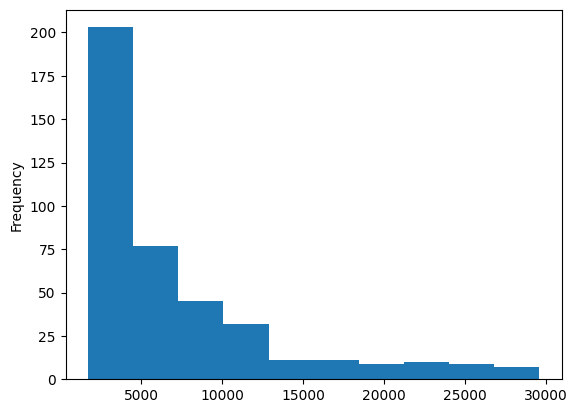

In [10]:
#Lets get rid of them
df = df[df['like'] < Q3 + 1.5 * IQR]

df['like'].plot.hist()

In [11]:
#How many Ads didnt get any likes?
print(df[df['like'] == 0].shape)

(0, 20)


Axes(0.125,0.11;0.775x0.77)


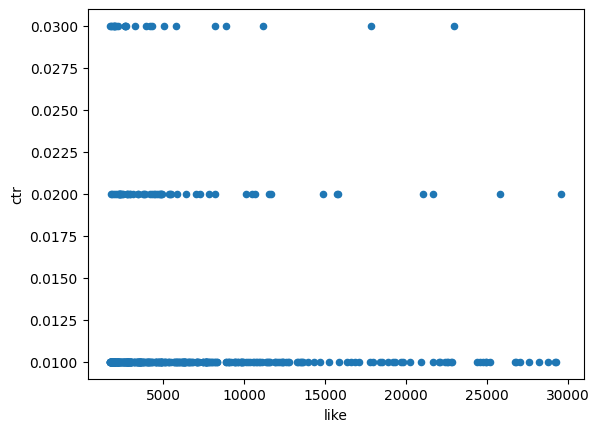

In [12]:
#Is any relationship between likes and CTR?
print(df.plot.scatter(x='like', y='ctr'))
plt.show();

In [13]:
df[['like', 'ctr']].corr()

,like,ctr
like,1.000000,-0.074356
ctr,-0.074356,1.000000


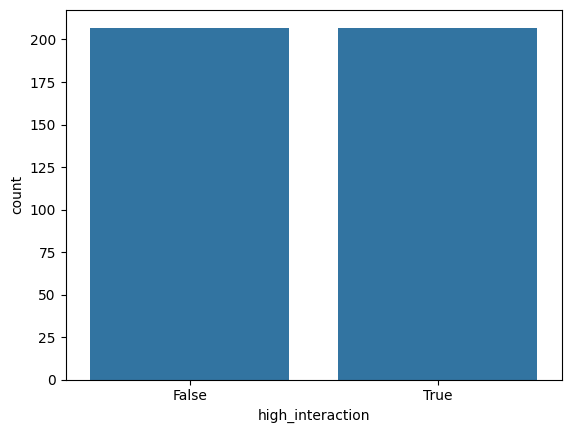

In [14]:
#Originally I wanted to use CTR as target, but somehow it only has three values: 0.001, 0.002 and 0.003. And is not correlatin with likes. 
#So lets use likes as target.

#To make the problem a bit more easy, lets aim to predict high interaction ads (top likes)
df['high_interaction'] = df['like'] > df['like'].median()
df['high_interaction'].value_counts()
#Now lets see if there's any relationship between the features and the target
sns.countplot(x='high_interaction', data=df)
plt.show();


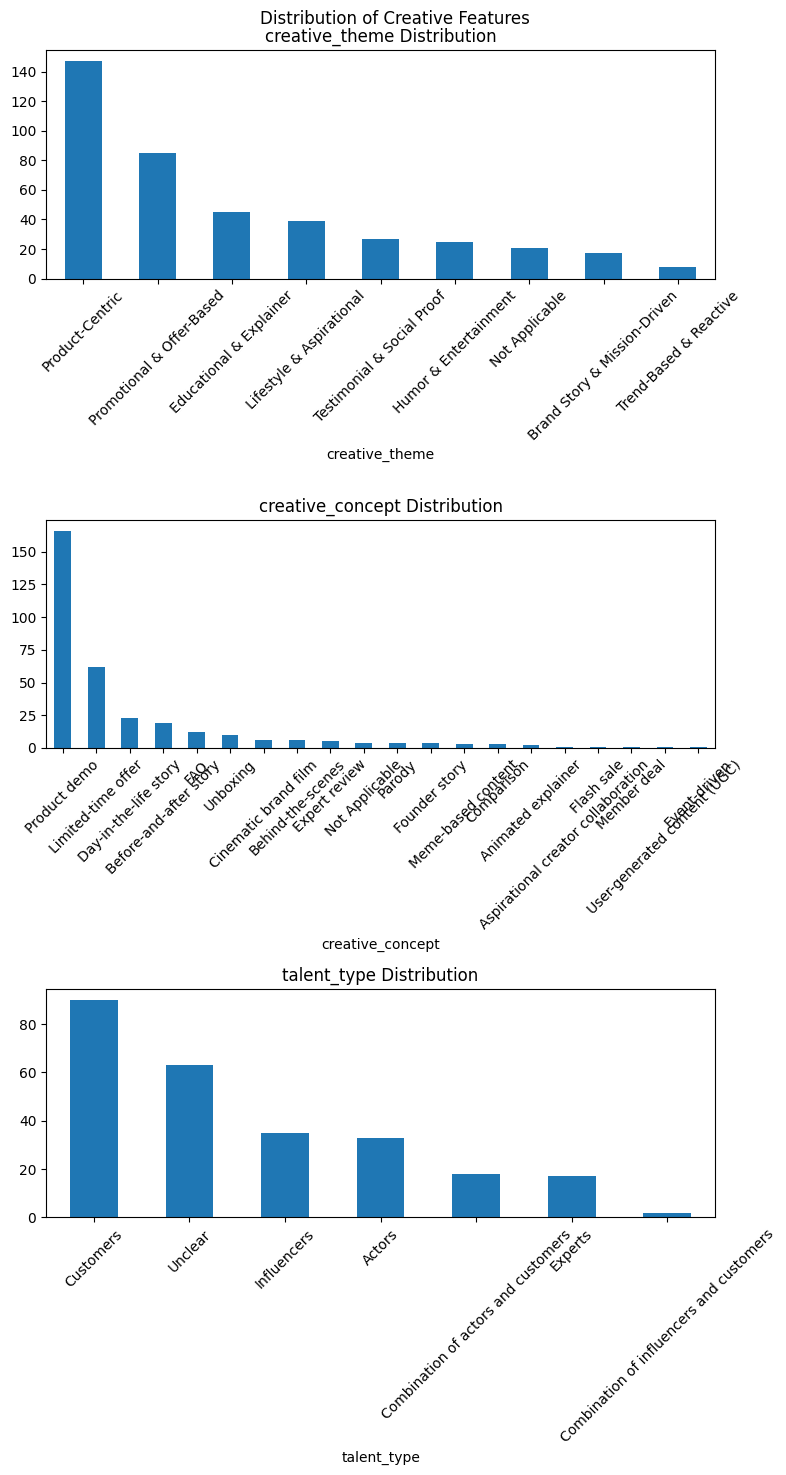

In [19]:
#to-do: we need to understand the cardinality of the creative features. Lets plot the value counts of each feature

# Create a figure with subplots in a grid
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
fig.suptitle('Distribution of Creative Features')

# Flatten axes array for easier iteration
axes = axes.flatten()

# Features to plot
features = ['creative_theme', 'creative_concept', 
           'talent_type']

# Plot each feature
for i, feature in enumerate(features):
    df[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')
    axes[i].tick_params(axis='x', rotation=45)
    
# Remove empty subplots if any
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [87]:
#One way to reduce the cardinality of the creative features is to group them into a few categories given a pareto principle

#Lets group them into a few categories given a pareto principle
def pareto_grouping(series, threshold=0.8):
    """
    Groups categories in a series based on the Pareto principle.
    Categories that make up 80% of occurrences are kept, the rest are grouped as 'Others'.
    
    Args:
        series: pandas Series containing categorical data
        threshold: float, cumulative percentage threshold (default 0.8 for 80%)
    
    Returns:
        pandas Series with grouped categories
    """
    # Calculate value counts and cumulative percentages
    value_counts = series.value_counts()
    cum_percentages = value_counts.cumsum() / value_counts.sum()
    
    # Get categories that make up threshold% of occurrences
    major_categories = cum_percentages[cum_percentages <= threshold].index
    
    # Create new series with grouped categories
    return series.apply(lambda x: x if x in major_categories else 'Others')

# Apply pareto grouping to each creative feature
for feature in features:
    print(f"\n{feature} - Original value counts:")
    print(df[feature].value_counts())
    
    df[feature] = pareto_grouping(df[feature])
    
    print(f"\n{feature} - After pareto grouping:")
    print(df[feature].value_counts())



creative_theme - Original value counts:
creative_theme
Product-Centric                 147
Promotional & Offer-Based        85
Educational & Explainer          45
Lifestyle & Aspirational         39
Testimonial & Social Proof       27
Humor & Entertainment            25
Not Applicable                   21
Brand Story & Mission-Driven     17
Trend-Based & Reactive            8
Name: count, dtype: int64

creative_theme - After pareto grouping:
creative_theme
Product-Centric              147
Others                        98
Promotional & Offer-Based     85
Educational & Explainer       45
Lifestyle & Aspirational      39
Name: count, dtype: int64

creative_concept - Original value counts:
creative_concept
Product demo                          166
Limited-time offer                     62
Day-in-the-life story                  23
Before-and-after story                 19
FAQ                                    12
Unboxing                               10
Cinematic brand film               

In [88]:
df.head()

,ad_title,cost,ctr,id,like,is_ugc,duration,height,width,industry_parent,industry_child,objective_value,creative_theme,creative_concept,format_production_style,talent_type,demographic_representation,audience_focus,campaign_objective,high_interaction
1,Oddly satisfying game,2,0.01,7109275920046178305,14299,False,37.334,1024.0,576.0,News & Entertainment,Games & Utility Software,App Installs,Product-Centric,Product demo,Others,Others,No People Featured,Others,Awareness,True
2,My friend recommended me to play this game,0,0.02,7077499601561305089,2427,False,17.323,1024.0,576.0,News & Entertainment,Games & Utility Software,App Installs,Educational & Explainer,Product demo,Others,Others,No People Featured,Others,Awareness,False
4,Play ten minutes a day to relieve stress!,0,0.02,7077499507373899777,2739,True,14.016,1024.0,576.0,News & Entertainment,Games & Utility Software,App Installs,Product-Centric,Product demo,Others,Others,No People Featured,Others,App Promotion,False
5,Stay social while social-distancing.,1,0.02,7140228677053972482,5491,True,19.318,1280.0,720.0,News & Entertainment,Relationship Information,App Installs,Others,Others,Others,Customers,Primarily Female,Others,App Promotion,True
6,Swallow 'em all,1,0.03,7228439319760535554,1811,True,25.250,1280.0,720.0,News & Entertainment,Other News & Entertainment,App Installs,Others,Product demo,Others,Others,Others,Others,App Promotion,False


In [89]:
#Ok cool, now lets transform the text features into numerical features with one-hot encoding
df = pd.get_dummies(df, columns=['industry_parent', 'industry_child', 'objective_value', 'creative_theme', 'creative_concept', 'format_production_style', 'talent_type', 'demographic_representation', 'audience_focus', 'campaign_objective'])


In [90]:
#Print the dtypes
print(df.dtypes)

#Lets drop the id column
df = df.drop(columns=['id', 'ad_title'])

ad_title                             object
cost                                  int64
ctr                                 float64
id                                    int64
like                                  int64
                                     ...   
audience_focus_Unclear                 bool
campaign_objective_App Promotion       bool
campaign_objective_Awareness           bool
campaign_objective_Others              bool
campaign_objective_Sales               bool
Length: 170, dtype: object


In [91]:
df.head()

,cost,ctr,like,is_ugc,duration,height,width,high_interaction,industry_parent_Apparel & Accessories,industry_parent_Appliances,...,demographic_representation_Primarily Male,demographic_representation_Unclear,audience_focus_Others,audience_focus_Problem Aware,audience_focus_Solution Aware,audience_focus_Unclear,campaign_objective_App Promotion,campaign_objective_Awareness,campaign_objective_Others,campaign_objective_Sales
1,2,0.01,14299,False,37.334,1024.0,576.0,True,False,False,...,False,False,True,False,False,False,False,True,False,False
2,0,0.02,2427,False,17.323,1024.0,576.0,False,False,False,...,False,False,True,False,False,False,False,True,False,False
4,0,0.02,2739,True,14.016,1024.0,576.0,False,False,False,...,False,False,True,False,False,False,True,False,False,False
5,1,0.02,5491,True,19.318,1280.0,720.0,True,False,False,...,False,False,True,False,False,False,True,False,False,False
6,1,0.03,1811,True,25.250,1280.0,720.0,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [92]:
corr = df.corr()

#Lets find if there are any highly correlated features
#Get the upper triangle of the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

#Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.5)]
print(to_drop)

['high_interaction', 'industry_child_Auto Accessories', 'industry_child_Beauty & Personal Care', 'industry_child_Celebrities & Gossip', 'industry_child_Cell Phones', 'industry_child_Clothing Accessories', 'industry_child_Cosmetics', 'industry_child_Electric Scooters', 'industry_child_Food & Fresh Produce', 'industry_child_Furniture', 'industry_child_Higher Education', 'industry_child_Home Appliances', 'industry_child_Hyper-Casual', 'industry_child_Large E-commerce Platforms', 'industry_child_Loan Services', 'industry_child_Marketing & Advertising', 'industry_child_Medical Information', 'industry_child_Medical Services', "industry_child_Men's Clothing", 'industry_child_Non-academic Training (Hobbies)', 'industry_child_Non-alcoholic Beverages', 'industry_child_Other Baby, Kids & Maternity', 'industry_child_Pet Household Products', 'industry_child_Skincare', 'industry_child_Sports & Equipment', 'industry_child_Sports & Outdoor', 'industry_child_Tours & Attractions', 'industry_child_Travel

### Is UGC

In [93]:
df['is_ugc'].value_counts()

is_ugc
True     326
False     88
Name: count, dtype: int64

### Aspect Ratio

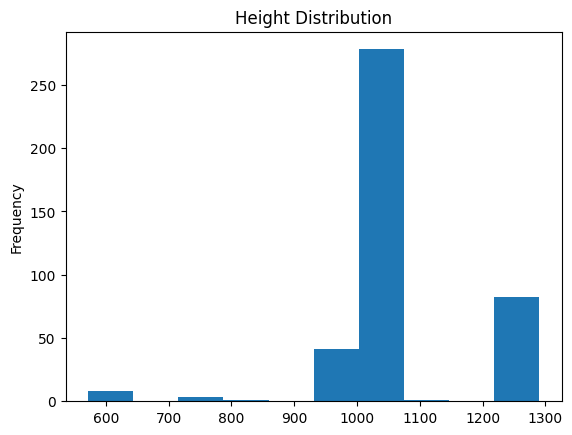

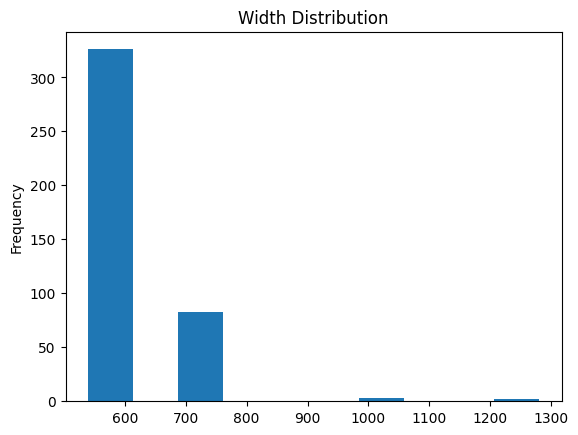

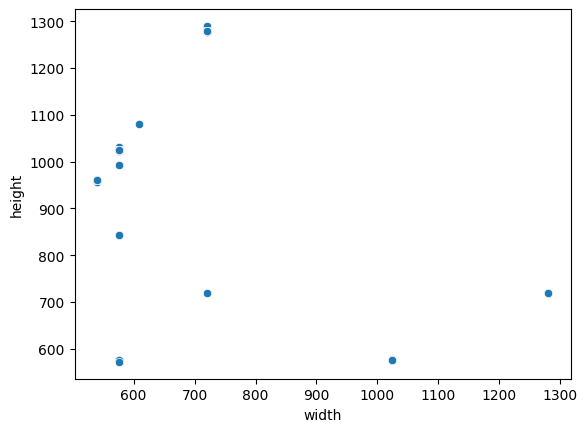

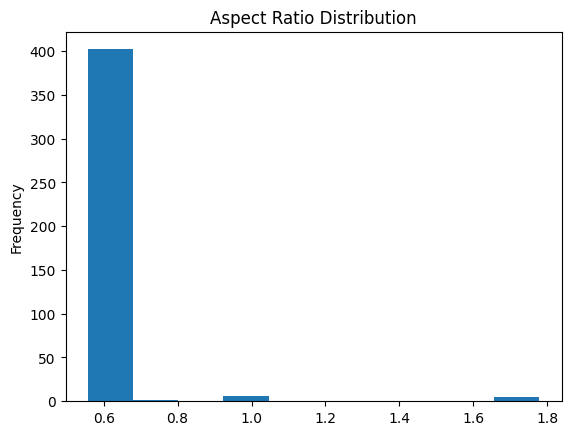

In [99]:
df['height'].plot.hist(title='Height Distribution')
plt.show();
df['width'].plot.hist(title='Width Distribution')
plt.show();
sns.scatterplot(x='width', y='height', data=df)
plt.show();
df['aspect_ratio'] = df['width'] / df['height']
df['aspect_ratio'].plot.hist(title='Aspect Ratio Distribution')
plt.show();

In [102]:
#Export the DataFrame to a CSV file
df.to_csv('../../data/datasets/tiktok_topads_clean_transformed.csv', index=False)


### Report

In [ ]:
# report = ProfileReport(df, title="Quick EDA Report", explorative=True)
# report.to_file("report.html")

Summarize dataset:  98%|█████████▊| 190/193 [00:36<00:00,  5.06it/s, Detecting duplicates]                        /Users/camilojaureguiberry/Documents/Projects/Developments/NarrativeLens/NarrativeLens/lib/python3.10/site-packages/ydata_profiling/model/pandas/duplicates_pandas.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[duplicated_rows]
/Users/camilojaureguiberry/Documents/Projects/Developments/NarrativeLens/NarrativeLens/lib/python3.10/site-packages/ydata_profiling/model/pandas/duplicates_pandas.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 